<a href="https://colab.research.google.com/gist/tyty9798123/b1db876a42a88bcca31a0ea28b1db223/experiment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [ ]:
import numpy as np
import pandas as pd
import os

import time
import datetime
import glob

import warnings
warnings.filterwarnings("ignore")

from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["figure.dpi"] = 300
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import ClusterCentroids
from sklearn.ensemble import BaggingClassifier

import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

## Change Time Zone

In [ ]:
!date -R
os.environ["TZ"] = "America/New_York"
time.tzset()
!date -R

Mon, 02 Jan 2023 14:14:16 +0000
Mon, 02 Jan 2023 09:14:16 -0500


## Load Data

In [ ]:
dir = './drive/MyDrive/stocktwits_dataset'
symbol = 'SPY'
my_dir = os.path.join(dir, symbol)

In [ ]:
saved_path = os.path.join(my_dir, symbol+'_concat_files_with_all.csv') # read machine-labeled and user-labeled
df = pd.read_csv(saved_path)

In [ ]:
df.head()

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  \
0     1419711             0               0   
1           0             1              24   
2     1419712             2               1   
3           1             3              21   
4     1419713             4               2   

                                            Sentence      Timestamp  \
0          watching squawk box im losing brain cells  1584964231000   
1                               $SPY there’s no cure  1584964276000   
2      \n\nIts only just beginning. \n\nThere are...  1584964278000   
3                                         $SPY uh oh  1584964308000   
4   Im in a NY hospital with my mom. They don&#39...  1584964331000   

              DateTime Sentiment  
0  2020/03/23 07:50:31   Bullish  
1  2020/03/23 07:51:16   Bearish  
2  2020/03/23 07:51:18   Bearish  
3  2020/03/23 07:51:48   Bullish  
4  2020/03/23 07:52:11   Bearish

## Load Historical Stock Data

In [ ]:
fin_dir = os.path.join('./drive/MyDrive/stocktwits_dataset', 'Financial', symbol+'.csv')
fin_df = pd.read_csv(fin_dir)
fin_df.head()

Date      Open      High       Low     Close      VWAP    Volume  \
0  2022-05-31  411.7713  414.6688  408.2665  411.1540  411.4038  95718004   
1  2022-05-27  406.1556  413.5935  405.9465  413.4740  410.7660  84653856   
2  2022-05-26  396.9553  405.2893  396.7363  403.5668  402.7934  81933455   
3  2022-05-25  390.6227  397.7320  390.2045  395.6609  394.1357  91225026   
4  2022-05-24  390.8716  393.4505  385.2957  392.1959  389.3216  91251910   

   Change Percent  Change  Trade Value  
0          -0.561 -2.3200  39554271900  
1           2.455  9.9072  34898718400  
2           1.998  7.9059  33104555200  
3           0.883  3.4650  36106475400  
4          -0.763 -3.0170  35712086900

## Load Historcial Stock Price (Intraday)

In [ ]:
# intraday stock price (15 mins update)
path_15mins = './drive/MyDrive/stocktwits_dataset/fifteen_mins/' + symbol
all_files = glob.glob(
    os.path.join(path_15mins, '*.csv')
)
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

fifteen_mins_df = pd.concat(li, axis=0, ignore_index=True)
fifteen_mins_df = fifteen_mins_df.drop_duplicates(subset=['time'])
# Divide DateTime
Dates = []
Times = []
for index, row in fifteen_mins_df.iterrows():
  Dates.append(
      row["time"].split(" ")[0]
  )
  Times.append(
      row["time"].split(" ")[1]
  )
fifteen_mins_df["Date"] = Dates
fifteen_mins_df["Time"] = Times
fifteen_mins_df = fifteen_mins_df.drop(columns=['time'])
fifteen_mins_df.head()

## Add Column Open Timestamp

In [ ]:
# Open Timestamp is the timestamp at open(9:30 AM)
Open_Timestamp = []
for i in range(len(fin_df)):
    temp = time.mktime(datetime.datetime.strptime(fin_df["Date"][i], "%Y-%m-%d").timetuple()) + (9.5*60*60)
    Open_Timestamp.append(int(temp))
fin_df["Open Timestamp"] = Open_Timestamp
fin_df.head()

## Keey Only Date, Open Timestamp, Change Percent

In [ ]:
fin_tmp_df = DataFrame()
fin_tmp_df["Date"] = fin_df["Date"]
fin_tmp_df["Open Timestamp"] = fin_df["Open Timestamp"]
fin_tmp_df["Change Percent"] = fin_df["Change Percent"]
fin_tmp_df.head()

## Get Sentiment Index

In [ ]:
def get_sentiment_index_two_class(concated, timestamp, hour_1, hour_2): 
  open_timestamp = timestamp
  filter1 = concated['Timestamp'] < (open_timestamp - hour_1 *(60*60) ) * 1000
  filter2 = concated["Timestamp"] > (open_timestamp - hour_2 *(60*60) ) * 1000
  concated = concated.where(filter1 & filter2)
  tmp = concated.dropna(subset=["Timestamp"])
  t = tmp.where( tmp['Sentiment'] == 'Bullish' )
  t = t.dropna(subset=["Timestamp"])
  num_of_positive = t.count()["Sentiment"]
  num_of_negative = tmp.count()["Sentiment"] - t.count()["Sentiment"]
  return np.log( (1+num_of_positive) / (1+num_of_negative) )

## Get Previous Financial Data

In [ ]:
def getPrevFinancialData(Date):
  current_index = fin_df.where(fin_df["Date"] == Date).dropna(subset=["Date"]).index[0]
  prev_index = current_index + 1
  return fin_df.iloc[prev_index]

In [ ]:
def getPrevFinancialDataWithDay(Date, num_of_days):
  current_index = fin_df.where(fin_df["Date"] == Date).dropna(subset=["Date"]).index[0]
  prev_index = current_index + num_of_days
  return fin_df.iloc[prev_index]

## Function of Get Percentage Change

In [ ]:
def get_percentage_change_with_mins(date, time):
  tmp = fifteen_mins_df[(fifteen_mins_df.Date == date) & (fifteen_mins_df.Time == time)]
  tmp = tmp.dropna(subset=["Time"])
  tmp['open'] = tmp['open'].apply(lambda x: float(x))
  tmp['high'] = tmp['high'].apply(lambda x: float(x))
  tmp['low'] = tmp['low'].apply(lambda x: float(x))
  tmp['close'] = tmp['close'].apply(lambda x: float(x))

  return tmp

In [ ]:
float( get_percentage_change_with_mins('2022-02-15', "16:00:00")["close"] )

NameError: ignored

In [ ]:
def split(word):
    return [char for char in word]

In [ ]:
time = "1200"
num = 10
generated_file_name = f'processed_2020_with_{time}_{num}.csv'
print(generated_file_name)

processed_2020_with_1200_10.csv



## Generate the data Before training.

In [ ]:
dataset = DataFrame()
concat_path = saved_path
concated = pd.read_csv(concat_path)

#Features
positive_percent_pre_market = [] #04:00~9:30 0, 5.5
positive_percent_55_95 = [] #00:00~04:00
positive_percent_95_135 = [] #20:00~00:00
positive_percent_after_market = [] #16:00~20:00
positive_percent_55_135 = []
positive_percent_yesterday_market = []
positive_percent_the_day_before_yesterday = []
positive_sum_pre_market = []
negative_sum_pre_market = []

positive_sum_55_95 = []
negative_sum_55_95 = []

positive_sum_95_135 = []
negative_sum_95_135 = []

positive_sum_after_market = []
negative_sum_after_market = []

positive_sum_yesterday_market = []
negative_sum_yesterday_market = []

sentiment_number_24hr = []
dates = []

prev_open = []
prev_high = []
prev_low =[]
prev_close = []
prev_volume = []
prev_change_percent = []
prev_vwap = []
prev_trade_value = []
prev_hlpct = []
today_open = []
day_of_the_week = []
premarkets = []
percentage_change = []
for index, row in fin_tmp_df.iterrows():
  timestamp = row['Open Timestamp']# + 2 * 60 * 60
  print(row["Date"])
  print(index+1)
  try:

    open = float(get_percentage_change_with_mins(row["Date"], "09:30:00")['close'])
    close = float(get_percentage_change_with_mins(row["Date"], 
         f"{split(time)[0]}{split(time)[1]}:{split(time)[2]}{split(time)[3]}:00")['close'])
  except:
    print("error")
    break
  # 星期幾欄位
  
  temp = pd.Timestamp(row["Date"])
  day_of_the_week.append(int(temp.dayofweek+1))
  dates.append(
      row["Date"]
  )
  # Positive Percent
  positive_percent_pre_market.append(
      get_sentiment_index_two_class(concated, timestamp, 0, 5.5) #0~5.5為正常
  )
  positive_percent_55_95.append(
      get_sentiment_index_two_class(concated, timestamp, 5.5, 9.5)
  )

  positive_percent_95_135.append(
      get_sentiment_index_two_class(concated, timestamp, 9.5, 13.5)
  )
  positive_percent_55_135.append(
      get_sentiment_index_two_class(concated, timestamp, 5.5, 13.5)
  )
  
  positive_percent_after_market.append(
      get_sentiment_index_two_class(concated, timestamp, 13.5, 17.5)
  )
  positive_percent_yesterday_market.append(
      get_sentiment_index_two_class(concated, timestamp, 17.5, 24)
  )
  positive_percent_the_day_before_yesterday.append(
      get_sentiment_index_two_class(concated, timestamp, 24, 48)
  )
  """
  sentiment_number_24hr.append(
      getSentimentSum(concated, timestamp, 0, 24)[0] + getSentimentSum(concated, timestamp, 0, 24)[1]
  )"""

  # Previous Day Data
  prev_open.append(
      getPrevFinancialData(row["Date"])["Open"]
  )
  prev_high.append(
      getPrevFinancialData(row["Date"])["High"]
  )
  prev_low.append(
      getPrevFinancialData(row["Date"])["Low"]
  )
  prev_close.append(
      getPrevFinancialData(row["Date"])["Close"]
  )
  prev_hlpct.append(
      (getPrevFinancialData(row["Date"])["High"] - getPrevFinancialData(row["Date"])["Low"]) / getPrevFinancialData(row["Date"])["Low"]
  )
  prev_volume.append(
      getPrevFinancialData(row["Date"])["Volume"]
  )
  
  prev_change_percent.append(
      ( getPrevFinancialData(row["Date"])["Close"] - getPrevFinancialData(row["Date"])["Open"] ) / getPrevFinancialData(row["Date"])["Open"]
      #getPrevFinancialData(row["Date"])["Change Percent"]
  )
  prev_vwap.append(
      getPrevFinancialData(row["Date"])["VWAP"]
  )
  prev_trade_value.append(
      getPrevFinancialData(row["Date"])["Trade Value"]
  )
  # Label
  percentage_change.append(
      ( close - open ) / open
  )
  print("totally appended")
# Features
dataset["Date"] = dates
dataset["day_of_the_week"] = day_of_the_week
dataset["positive_percent_pre_market"] = positive_percent_pre_market
dataset["positive_percent_55_135"] = positive_percent_55_135
dataset["positive_percent_55_95"] = positive_percent_55_95
dataset["positive_percent_95_135"] = positive_percent_95_135
dataset["positive_percent_after_market"] = positive_percent_after_market
dataset["positive_percent_yesterday_market"] = positive_percent_yesterday_market
dataset['positive_percent_the_day_before_yesterday'] = positive_percent_the_day_before_yesterday

#dataset["sentiment_number_24hr"] = sentiment_number_24hr

dataset["Prev Open"] = prev_open
dataset["Prev Close"] = prev_close
dataset["Prev High"] = prev_high
dataset["Prev Low"] = prev_low
dataset["Prev HLPCT"] = prev_hlpct
dataset["Prev Volume"] = prev_volume
dataset["Prev Change Percent"] = prev_change_percent
dataset["Prev Trade Value"] = prev_trade_value
dataset["Prev VWAP"] = prev_vwap
#dataset["Premarket Changed"] = premarkets
# Label
dataset["percentage_change"] = percentage_change

# 刪除有0或是空的列
print(dataset)

processed_path = os.path.join('./drive/MyDrive/stocktwits_dataset', symbol, generated_file_name)
dataset.to_csv(processed_path)

In [ ]:
processed_path = os.path.join('./drive/MyDrive/stocktwits_dataset', symbol, generated_file_name)
print(processed_path)

dataset = pd.read_csv(processed_path)
"""
dataset = dataset.drop(
    [
     'positive_percent_95_115',
     'positive_percent_115_135'
    ],
    axis=1
)"""
# Dele
dataset = dataset.drop(
    [
     #'sentiment_number_24hr',
     #'positive_percent_yesterday_market',
     #'Prev Open',
     #'Prev Close',
     #'Prev High',
     #'positive_percent_the_day_before_yesterday', #c
     #'Prev Low',
     #'Prev Volume',
     #'Prev Trade Value',
     'Prev VWAP',#c
     #'positive_percent_pre_market',
     'positive_percent_55_95',
     'positive_percent_55_135',
     'positive_percent_the_day_before_yesterday',
     'positive_percent_95_135',
     #'positive_percent_after_market',
     #'positive_percent_yesterday_market',
     'Prev HLPCT',#c
     #'Premarket Changed'
     #'positive_percent_55_135'#c,



     #"positive_percent_pre_market",
     #"positive_percent_after_market",
     #"positive_percent_yesterday_market"
    ],
    axis=1
)


dataset = dataset.drop(
    [
     'Unnamed: 0',
     #'day_of_the_week',
    ],
    axis=1
)
dataset["percentage_change"] = dataset["percentage_change"] * 100


days_of_week = pd.get_dummies(dataset.day_of_the_week)
dataset = pd.concat([dataset, days_of_week], axis=1)
temp_percentage_change = dataset["percentage_change"]
dataset = dataset.drop(["percentage_change"], axis=1)
dataset["percentage_change"] = temp_percentage_change
dataset = dataset.drop(['day_of_the_week'], axis=1)
dataset = dataset.drop(
    [
     1, 
     2, 
     3, 
     4, 
     5
    ],
    axis=1
)
end_index = dataset[dataset['Date']=='2022-02-28'].index[0]
start_testing_index = (len(dataset.index) - dataset[dataset['Date']=='2021-04-05'].index[0]) - 1
dataset = dataset[end_index:]
dataset = dataset.iloc[::-1]
print("End Index", end_index)
print("Start Testing Index", start_testing_index)
dataset

./drive/MyDrive/stocktwits_dataset/SPY/processed_2020_with_1200_10.csv
End Index 5
Start Testing Index 253


Date  positive_percent_pre_market  positive_percent_after_market  \
486  2020-04-01                    -0.730265                      -0.666907   
485  2020-04-02                    -0.543448                      -0.462420   
484  2020-04-03                    -0.322646                      -0.176489   
483  2020-04-06                    -0.033648                      -0.153111   
482  2020-04-07                     0.141114                      -0.101117   
..          ...                          ...                            ...   
9    2022-02-22                     0.215868                      -0.197087   
8    2022-02-23                    -0.031513                       0.200216   
7    2022-02-24                    -0.440312                      -0.421510   
6    2022-02-25                     0.151511                       0.216714   
5    2022-02-28                    -0.044562                      -0.227679   

     positive_percent_yesterday_market  Prev Open  Prev Close  Prev High  \
486                          -0.535102   253.9005    251.1623   256.5997   
485                          -0.719295   241.6421    239.8588   251.0738   
484                          -0.551196   238.9234    245.3937   246.2219   
483                          -0.132501   244.3510    241.8467   246.8456   
482                          -0.175813   251.2500    258.0906   260.1759   
..                                 ...        ...         ...        ...   
9                            -0.339051   437.3300    434.2300   438.6600   
8                            -0.251356   431.8900    429.5700   435.5000   
7                            -0.482259   432.6600    421.9500   433.2600   
6                             0.051182   411.0200    428.3000   428.7600   
5                            -0.206771   429.6100    437.7500   437.8400   

     Prev Low  Prev Volume  Prev Change Percent  Prev Trade Value  \
486  249.6715    193290928            -0.010785       49731996200   
485  237.6663    188373330            -0.007380       46454886300   
484  238.3387    176669824             0.027081       43613280900   
483  238.9526    134538553            -0.010249       33050036600   
482  241.8270    186692564             0.027226       48044974900   
..        ...          ...                  ...               ...   
9    431.8200    132414754            -0.007088       57720378000   
8    425.8600    124054581            -0.005372       53384444100   
7    421.3500    131884132            -0.024754       56332708600   
6    410.6400    213444305             0.042042       89499945200   
5    427.8600    121686081             0.018947       52825992700   

     percentage_change  
486           0.322646  
485           2.281811  
484          -1.006222  
483           1.147776  
482          -1.000146  
..                 ...  
9            -0.159655  
8            -0.882972  
7             1.861133  
6             1.659722  
5             1.217691  

[482 rows x 12 columns]

# Traning

In [ ]:
dataset.drop(["Date"], inplace=True, axis=1)
X, y = np.hsplit( dataset.to_numpy(), [-1])
_y = np.array(y>=0, dtype=int)

## Rolling Window

In [ ]:
def movement_data(X, y, current, n):
  
  X_train = X[current-n:current]
  y_train = y[current-n:current]
  
  
  #X_train = X[:current]
  #y_train = y[:current]
  
  X_test = X[current]
  y_test = y[current]
  return (X_train, np.array([X_test]), y_train, np.array([y_test]))

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import RobustScaler

history = []
history_w = []
history_score = []
range__ = [i for i in range(232, start_testing_index+1) if i % 2 == 0]

best_score = 0
best_n = 0
print(range__)
pred_his = []
c = 1
g = 'scale'
for i in range__:
  n=i
  score = 0
  count = 0
  preds = []
  while(True):
    try:
      start_num = n + count
      print(start_num, n)
      
      X_train, X_test, y_train, y_test = movement_data(X, _y, start_num, n)
      X_train, y_train = SMOTE(random_state=0, k_neighbors=5, n_jobs=-1).fit_resample(X_train, y_train)
      #標準化
      #scaler = StandardScaler()
      scaler = RobustScaler()
      scaler.fit(X_train) 
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)

      #訓練      
      bagging_clf = SVC().fit(X_train, y_train)
      #計算分數 0 or 1
      pred = bagging_clf.predict(X_test)[0]
      preds.append(pred)
      real = y_test[0][0]

      count+=1
      #答對
      if pred == real:
        score+=1
      #print("Score:", score)
      history.append(
          score / count
      )
      print(score / count)
    except:
      print("some exception occur")
      break
  pred_his.append(preds)
  if (score/count) > best_score:
    best_score = score/count
    best_n = n
    best_c = c
    best_g = g
  history_w.append(n)
  history_score.append(score / count)
  print("N:", n)
  print("Current Accuracy:", score / count)
  print("Best N:", best_n)
  print("Best Score:", best_score)

串流輸出內容已截斷至最後 5000 行。
405 232
0.5574712643678161
406 232
0.5542857142857143
407 232
0.5568181818181818
408 232
0.559322033898305
409 232
0.5617977528089888
410 232
0.5586592178770949
411 232
0.5611111111111111
412 232
0.56353591160221
413 232
0.5604395604395604
414 232
0.5628415300546448
415 232
0.5597826086956522
416 232
0.5621621621621622
417 232
0.5591397849462365
418 232
0.5614973262032086
419 232
0.5585106382978723
420 232
0.5608465608465608
421 232
0.5631578947368421
422 232
0.5654450261780105
423 232
0.5625
424 232
0.5647668393782384
425 232
0.5670103092783505
426 232
0.5692307692307692
427 232
0.5714285714285714
428 232
0.5736040609137056
429 232
0.5757575757575758
430 232
0.5728643216080402
431 232
0.575
432 232
0.572139303482587
433 232
0.5693069306930693
434 232
0.5714285714285714
435 232
0.5686274509803921
436 232
0.5658536585365853
437 232
0.5679611650485437
438 232
0.5700483091787439
439 232
0.5721153846153846
440 232
0.569377990430622
441 232
0.5666666666666667
442 232
0.

In [ ]:
pred_his =  np.array(pred_his)

f1_scores = []
for his in pred_his:
  labels = _y[start_testing_index:]
  preds = his[-(len(dataset)-start_testing_index):]
  #print( confusion_matrix(labels, preds) )
  #print( "Accuracy Score:", accuracy_score(labels, preds) )
  #print( "Precision。Score:", precision_score(labels, preds) )
  #print( "Recall Score:", recall_score(labels, preds) )
  print( "F1 Score:", f1_score(labels, preds) )
  f1_scores.append(f1_score(labels, preds))

F1 Score: 0.5652173913043478
F1 Score: 0.5872340425531916
F1 Score: 0.5565217391304348
F1 Score: 0.560344827586207
F1 Score: 0.5550660792951543
F1 Score: 0.5339366515837104
F1 Score: 0.5814977973568282
F1 Score: 0.5414847161572053
F1 Score: 0.5714285714285715
F1 Score: 0.5398230088495575
F1 Score: 0.5614035087719299


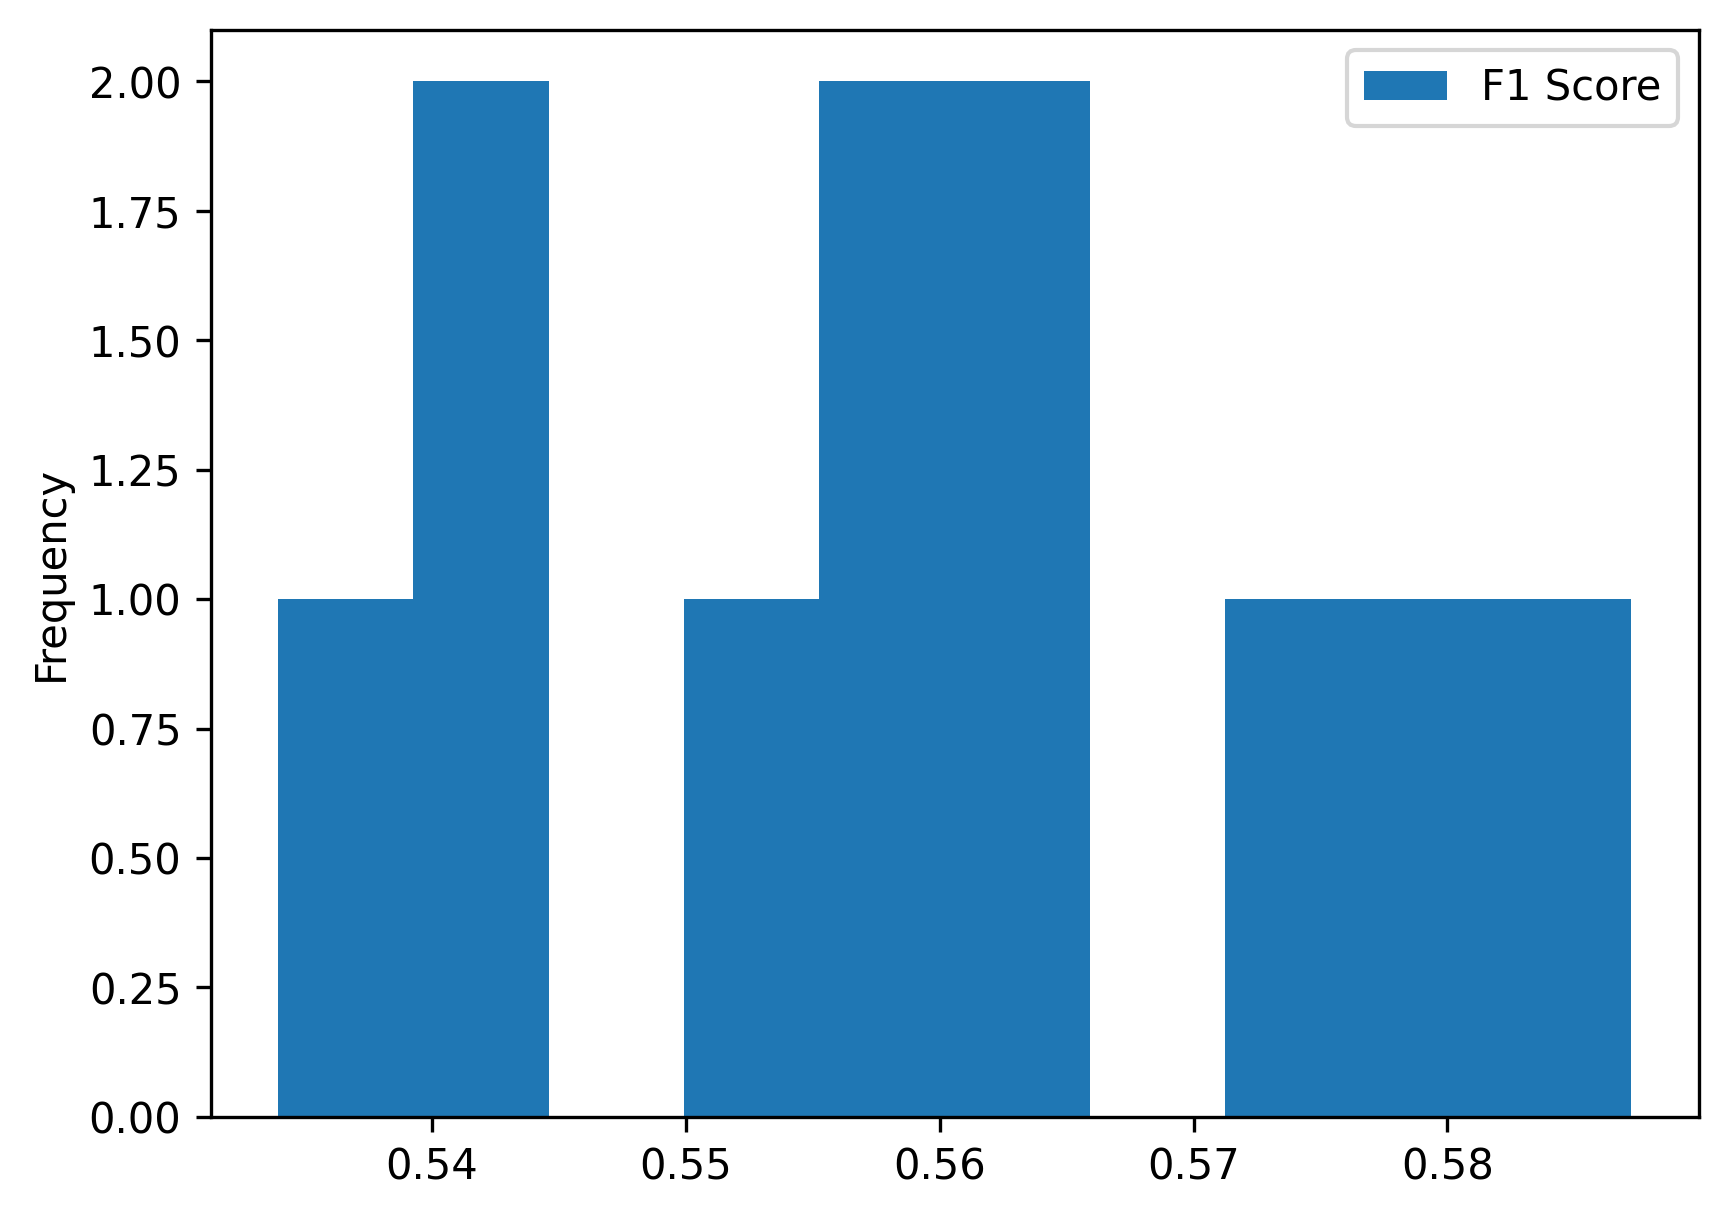

In [ ]:
d = pd.DataFrame()
d["Window Size"] = [str(i) for i in range__]
d["F1 Score"] = f1_scores
d.plot(x="Window Size", y="F1 Score", kind="hist") 

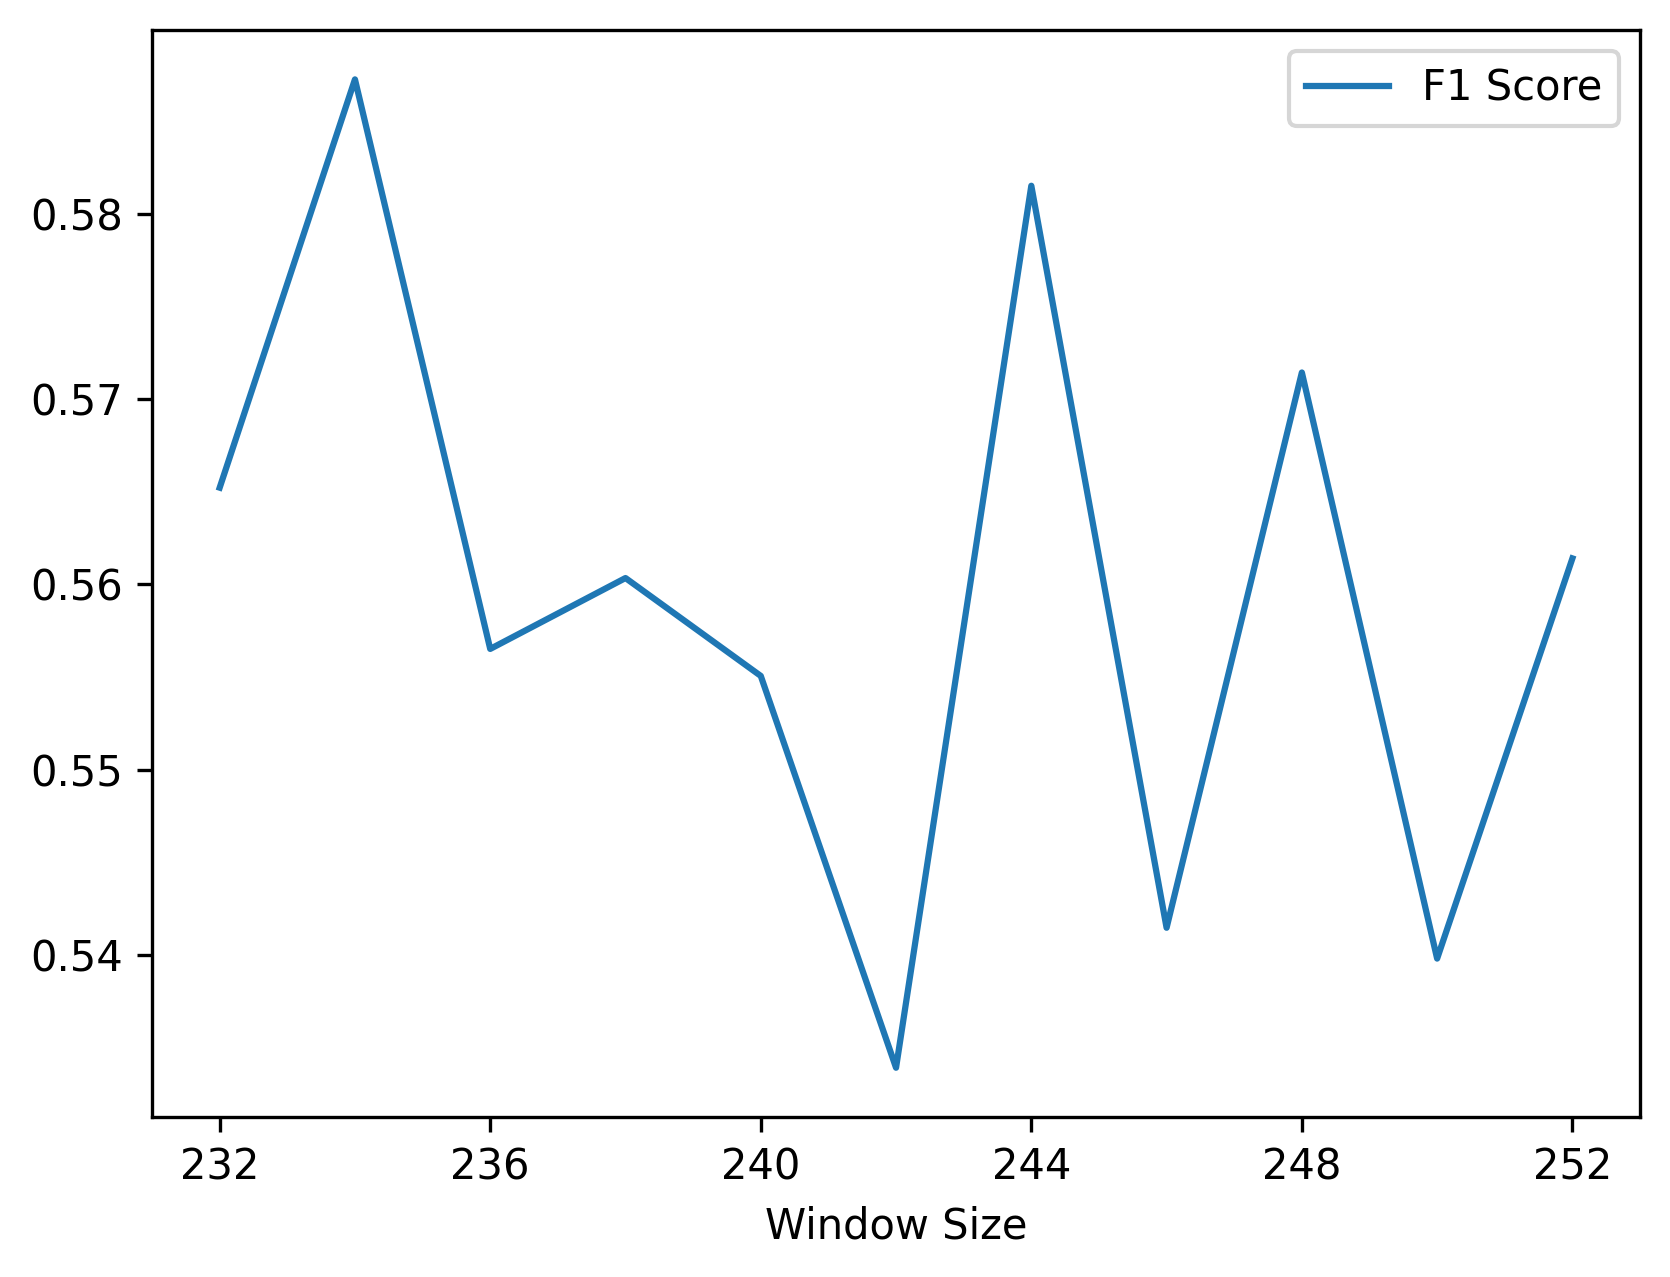

In [ ]:
d.plot(x="Window Size", y="F1 Score", kind="line") 

## Confusion Matrix

In [ ]:
start = start_testing_index
_y = _y[start:]
preds = preds[- ( len(X) - start ):]
print( confusion_matrix(_y, preds) )
print( "Accuracy Score:", accuracy_score(_y, preds) )
print( "Precision Score:", precision_score(_y, preds) )
print( "Recall Score:", recall_score(_y, preds) )
print( "F1 Score:", f1_score(_y, preds) )

[[65 44]
 [56 64]]
Accuracy Score: 0.5633187772925764
Precision Score: 0.5925925925925926
Recall Score: 0.5333333333333333
F1 Score: 0.5614035087719299
